In [219]:
import pandas as pd
from datetime import datetime
from math import sqrt
import numpy as np
import matplotlib.pyplot as plt
import requests
import pandas_datareader.data as web
import seaborn as sns
import statsmodels.api as sm
from arch import arch_model
import arch
import scipy
from scipy.stats import t
from scipy.optimize import fmin
import warnings
import os
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

%matplotlib inline

In [220]:
ativos = ['RADL3', 'BRML3','ABEV3','PCAR4']
N = len(ativos)
cotacoes_list = []   
for x in ativos:
    cotacoes_list.append( web.DataReader(x + ".SA", data_source='yahoo', start='1/1/2014', end = '3/20/2016')['Close'])

In [221]:

cotacoes = pd.DataFrame(index = ativos, data = cotacoes_list).transpose().dropna()
cotacoes_carteira = cotacoes.sum(axis=1)/4

In [222]:
def log_retorno(cotacoes):
    return np.log((cotacoes.shift(1) / cotacoes))[1:]

In [223]:
retornos = [log_retorno(cotacoes_list[x]) for x in range(len(cotacoes_list))]
retornos = pd.DataFrame(index = ativos, data = retornos)
retornos = retornos.transpose().dropna()
retornos = retornos[retornos!=0].dropna()
retornos_carteira = retornos.sum(axis=1)/4

In [229]:
def CopulaTVaR(retornos):
    
    arch_model_fit = []
    N = len(retornos.columns)
    
    retornos.to_csv('retornos.csv')
    os.system('R < fitArch.R --no-save')
    
    parametros = pd.read_csv('parametros.csv')
    parametros = parametros.drop('Unnamed: 0', 1).transpose()
    parametros.columns = ativos
    residuos = pd.read_csv('residuos.csv')
    residuos = residuos.drop('Unnamed: 0', 1).transpose().reset_index(drop=True)
    residuos.columns = ativos
    volatilidade_condicional = pd.read_csv('volatilidade.csv')
    volatilidade_condicional = volatilidade_condicional.drop('Unnamed: 0', 1).transpose().reset_index(drop=True)
    volatilidade_condicional.columns = ativos

    residuos_normalizados = residuos/volatilidade_condicional
    
    uniforms = pd.DataFrame()
    for x in range(N):
        uniforms[ativos[x]] = t.cdf(residuos_normalizados[ativos[x]],parametros[ativos[x]]['V8'])
        
    uniforms.to_csv('uniforms.csv')
    
    # chamando a copulafit do R
    
    os.system('R < copulafit.R --no-save')
    
    simulados = pd.read_csv('CopulaOtimaSimulada.csv')
    simulados = simulados.drop('Unnamed: 0', 1)
    
    simulado_final = pd.DataFrame()

    for x in range(N):
        simulado_final[ativos[x]] = t.ppf(simulados['V'+str(x+1)], parametros[ativos[x]]['V8'], loc=parametros[ativos[x]]['V1'], scale=volatilidade_condicional[ativos[x]].iloc[-1])     

    return simulado_final.sum(axis=1)/4

In [230]:
lista_var95 = []
lista_var99 = []
lista_var90 = []
count95 = 0
count99 = 0
count90 = 0
inicio = len(retornos_carteira) - 255
final = len(retornos_carteira)
for x in range(inicio,final):
    var = CopulaTVaR(retornos[x-255:x])
    
    
    lista_var95.append(var.quantile(0.05))
    if lista_var95[-1] > retornos_carteira.iloc[x-1]:
        count95 += 1
        
    lista_var90.append(var.quantile(0.1))
    if lista_var90[-1] > retornos_carteira.iloc[x-1]:
        count90 += 1
        
    lista_var99.append(var.quantile(0.01))
    if lista_var99[-1] > retornos_carteira.iloc[x-1]:
        count99 += 1

In [231]:
retornos_carteira_plot = retornos_carteira[inicio:final]

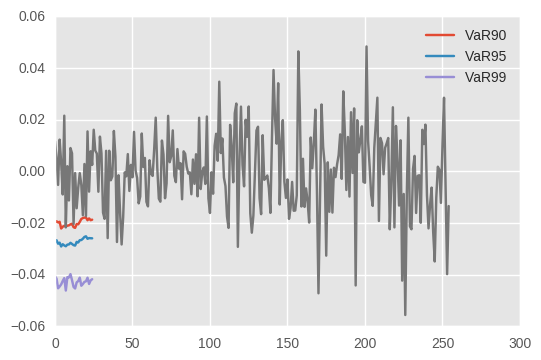

In [232]:
plt.plot(lista_var90, label = 'VaR90')
plt.plot(lista_var95, label = 'VaR95')
plt.plot(lista_var99, label = 'VaR99')
plt.plot(retornos_carteira_plot.as_matrix())
plt.legend()

In [233]:
backtesting_copula = pd.DataFrame([count90,count95,count99] , index = ["VaR 90","VaR 95","VaR 99"], columns =  ["Excecoes para 252 dias"])
backtesting_copula["T = 255 dias"] = ["16<N<36","6<N<21","N<7"]
backtesting_copula

,Excecoes para 252 dias,T = 255 dias
VaR 90,0,16<N<36
VaR 95,0,6<N<21
VaR 99,0,N<7


In [234]:
lista_var95

[-0.027473429602962344,
 -0.026685267471981258,
 -0.028037099505078763,
 -0.02764145477545727,
 -0.029110892387590733,
 -0.028232127013089428,
 -0.028712662952398837,
 -0.029024463159064054,
 -0.02838767277016515,
 -0.028325250544051946,
 -0.027694256455675484,
 -0.028135478285846754,
 -0.028595580674822686,
 -0.02876366286899195,
 -0.027328099095644466,
 -0.02754845987117767,
 -0.026673190174717157,
 -0.026620430284608216,
 -0.026101271715151246,
 -0.02541215233832886,
 -0.025173018893054403,
 -0.02613770098997309,
 -0.02586065290193826,
 -0.025917649518224745,
 -0.025949539844596706]

In [131]:
retornos

,RADL3,BRML3,BBDC4,PCAR4
Date,,,,
2014-01-03,-0.015298,0.028381,-0.011817,-0.017421
2014-01-06,0.016617,-0.032499,0.008361,-0.016631
2014-01-07,0.005260,0.005881,-0.022083,-0.002599
2014-01-08,0.000000,0.021468,-0.000709,-0.004112
2014-01-09,-0.036732,-0.036238,-0.029144,-0.030094
2014-01-10,0.009479,0.014771,0.008359,-0.004359
2014-01-13,-0.037067,-0.008246,-0.007264,0.010039
2014-01-14,0.030984,-0.007121,0.009076,0.011366
2014-01-15,-0.002716,0.020629,0.005766,0.007910


In [127]:
a,b,c = CopulaTVaR(retornos[53:308])

/usr/local/lib/python3.5/dist-packages/arch/univariate/base.py:510: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


In [130]:
retornos[53:308].mean()

RADL3    0.001821
BRML3   -0.000214
BBDC4    0.000185
PCAR4   -0.000055
dtype: float64

In [129]:
b

,RADL3,BRML3,BBDC4,PCAR4
Const,1.705559e-03,0.000285,0.001131,-308.726346
omega,4.759117e-05,0.000010,0.000014,0.000000
alpha[1],1.005092e-07,0.094651,0.060382,0.037765
beta[1],8.445357e-01,0.897107,0.924511,0.962477
nu,1.290133e+01,12.358660,6.161468,7.173265


In [81]:
retornos = retornos[42:297]

In [82]:
arch_model_fit = []
N = len(retornos.columns)
    
for x in range(N):
        arch_model_fit.append(arch.arch_model(retornos.ix[:,x], mean='AR', vol='GARCH', dist = 'StudentsT').fit(disp='off'))
        

/usr/local/lib/python3.5/dist-packages/arch/univariate/base.py:510: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/arch/univariate/base.py:510: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


In [83]:
parametros = pd.DataFrame()
residuos = pd.DataFrame()
volatilidade_condicional = pd.DataFrame()

for x in range(N):
    parametros[ativos[x]] = arch_model_fit[x].params
    volatilidade_condicional[ativos[x]] = arch_model_fit[x].conditional_volatility
    residuos[ativos[x]] = arch_model_fit[x].resid